In [27]:
import databento as db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import math

In [28]:
df = pd.read_csv('Data/gold_futures_ohlcv.csv', parse_dates=['ts_event'])
df["ts_event"] = pd.to_datetime(df["ts_event"])
df.tail()

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
137701,2025-07-31 00:00:00+00:00,35,1,42100514,-27.2,-27.0,-27.8,-27.6,11260,GCV5-GCZ5
137702,2025-07-31 00:00:00+00:00,35,1,42066068,-14.8,-14.6,-14.9,-14.9,6,GCV5-GCX5
137703,2025-07-31 00:00:00+00:00,35,1,42031409,-23.5,-23.3,-24.2,-24.2,585,GCG6-GCJ6
137704,2025-07-31 00:00:00+00:00,35,1,42000890,3389.7,3413.4,3387.1,3398.9,48,GCJ6
137705,2025-07-31 00:00:00+00:00,35,1,42279763,-22.0,-22.0,-22.5,-22.1,49,GCQ6-GCV6


In [29]:
# filtering only vanilla futures data
single_contract_filter = (df["symbol"].str.len() == 4)
fdf = df[single_contract_filter].copy()

In [30]:
# determining contract year from symbol 

future_month_map = {
    'F': 1,   # January
    'G': 2,   # February
    'H': 3,   # March
    'J': 4,   # April
    'K': 5,   # May
    'M': 6,   # June
    'N': 7,   # July
    'Q': 8,   # August
    'U': 9,   # September
    'V': 10,  # October
    'X': 11,  # November
    'Z': 12   # December
}

def get_contract_year(row):
    contract_year_first_digit = int(row["symbol"][3])
    curr_year = row['ts_event'].year
    if contract_year_first_digit < curr_year % 10: 
        contract_year = math.ceil(row['ts_event'].year / 10) * 10 + contract_year_first_digit
    else:
        contract_year = math.floor(row['ts_event'].year / 10) * 10 + contract_year_first_digit
    return contract_year

fdf["contract_year"] = fdf.apply(get_contract_year, axis=1)
fdf["contract_month"] = fdf.apply(lambda row: future_month_map[row['symbol'][2]], axis=1)

In [31]:
# determine contract length
def get_expiry_length(row):
    month = future_month_map[row['symbol'][2]]
    year = row["contract_year"]
    return (month - row['ts_event'].month + 12 * (year - row['ts_event'].year))

fdf["expiry_length"] = fdf.apply(get_expiry_length, axis=1)

In [32]:
fdf.head()

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol,contract_year,contract_month,expiry_length
0,2010-06-06 00:00:00+00:00,35,1,197012,1225.8,1226.3,1223.8,1224.0,23,GCZ0,2010,12,6
2,2010-06-06 00:00:00+00:00,35,1,197015,1232.0,1232.0,1230.0,1230.0,3,GCM1,2011,6,12
4,2010-06-06 00:00:00+00:00,35,1,102338,1220.0,1221.4,1217.9,1218.0,27,GCN0,2010,7,1
5,2010-06-06 00:00:00+00:00,35,1,104313,1221.1,1222.5,1218.3,1218.9,2031,GCQ0,2010,8,2
6,2010-06-06 00:00:00+00:00,35,1,197009,1220.4,1220.7,1220.4,1220.7,2,GCM0,2010,6,0


In [33]:
# creating front month timeseries
fm_df = fdf[fdf["expiry_length"] <= 1].copy()
fm_df.head()

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol,contract_year,contract_month,expiry_length
4,2010-06-06 00:00:00+00:00,35,1,102338,1220.0,1221.4,1217.9,1218.0,27,GCN0,2010,7,1
6,2010-06-06 00:00:00+00:00,35,1,197009,1220.4,1220.7,1220.4,1220.7,2,GCM0,2010,6,0
23,2010-06-07 00:00:00+00:00,35,1,102338,1217.3,1245.3,1211.8,1240.1,848,GCN0,2010,7,1
44,2010-06-07 00:00:00+00:00,35,1,197009,1215.1,1244.7,1211.0,1241.6,860,GCM0,2010,6,0
54,2010-06-08 00:00:00+00:00,35,1,197009,1238.7,1252.1,1234.1,1237.0,761,GCM0,2010,6,0


In [34]:
fm_df["expiry_length"].value_counts()

1    4680
0    3670
Name: expiry_length, dtype: int64

In [35]:
# creating roll date
DAYS_BEFORE_EXPIRY = 3

def get_roll_date(row):
    year = row["contract_year"]
    month = row["contract_month"]
    bdays = pd.bdate_range(f"{year}-{month:02d}-01", f"{year}-{month:02d}-28")
    bdays = pd.bdate_range(bdays[0], bdays[-1] + pd.offsets.MonthEnd(0))
    bdays = bdays[bdays.month == month]
    roll_date = bdays[-3] - pd.Timedelta(days=DAYS_BEFORE_EXPIRY)
    if roll_date.weekday() == 5:
        roll_date = roll_date - pd.Timedelta(days=1)
    return roll_date

fm_df["roll_date"] = fm_df.apply(lambda row: row["ts_event"].date() == get_roll_date(row).date(), axis=1)

In [36]:
# making sure roll date is in relation to very front month
fm_df["roll_date"] = fm_df["roll_date"] & (fm_df["expiry_length"] == 0)

In [37]:
get_roll_date(fm_df.iloc[-1])

Timestamp('2025-08-24 00:00:00', freq='B')

In [38]:
# adjusting for roll
def roll_spread(df):
    roll_rows = df[df["roll_date"]]
    spreads = []
    for idx, row in roll_rows.iterrows():
        front_close = row["close"]
        mask = (df["ts_event"].dt.date == row["ts_event"].date()) & (df["expiry_length"] == 1)
        second_month = df[mask]
        if not second_month.empty:
            second_close = second_month.iloc[0]["close"]
            spreads.append(second_close - front_close)

    return spreads

fm_df["roll_adj"] = 0.0
roll_values = roll_spread(fm_df)
fm_df.loc[fm_df["roll_date"], "roll_adj"] = roll_values
fm_df["roll_adj_close"] = fm_df["close"] + np.cumsum(fm_df["roll_adj"][::-1])[::-1]

In [40]:
# splitting into front month and second month
frdf = fm_df.loc[fm_df["expiry_length"] == 0 & fm_df["ts_event"] <= fm_df["roll_date"]]
sdf = fm_df.loc[fm_df["expiry_length"] == 1 & fm_df["ts_event"] >= fm_df["roll_date"]]

TypeError: unsupported operand type(s) for &: 'int' and 'DatetimeArray'

In [26]:
fm_df["roll_adj_close"].plot()

KeyError: 'roll_adj_close'

Rows in the same month but past the roll date:
                      ts_event symbol        contract_roll_date
551  2010-06-28 00:00:00+00:00   GCM0 2010-06-25 00:00:00+00:00
1338 2010-07-26 00:00:00+00:00   GCN0 2010-07-25 00:00:00+00:00
1384 2010-07-27 00:00:00+00:00   GCN0 2010-07-25 00:00:00+00:00
1411 2010-07-28 00:00:00+00:00   GCN0 2010-07-25 00:00:00+00:00
2225 2010-08-25 00:00:00+00:00   GCQ0 2010-08-24 00:00:00+00:00

Continuous Rolled Contract Data:
                            close  next_close  spread  cumulative_adjustment  \
ts_event                                                                       
2010-06-06 00:00:00+00:00  1220.7      1218.0     0.0                  153.6   
2010-06-07 00:00:00+00:00  1241.6      1240.1     0.0                  153.6   
2010-06-08 00:00:00+00:00  1237.0      1236.5     0.0                  153.6   
2010-06-09 00:00:00+00:00  1231.6      1233.5     0.0                  153.6   
2010-06-10 00:00:00+00:00  1217.1      1219.2     0.0  

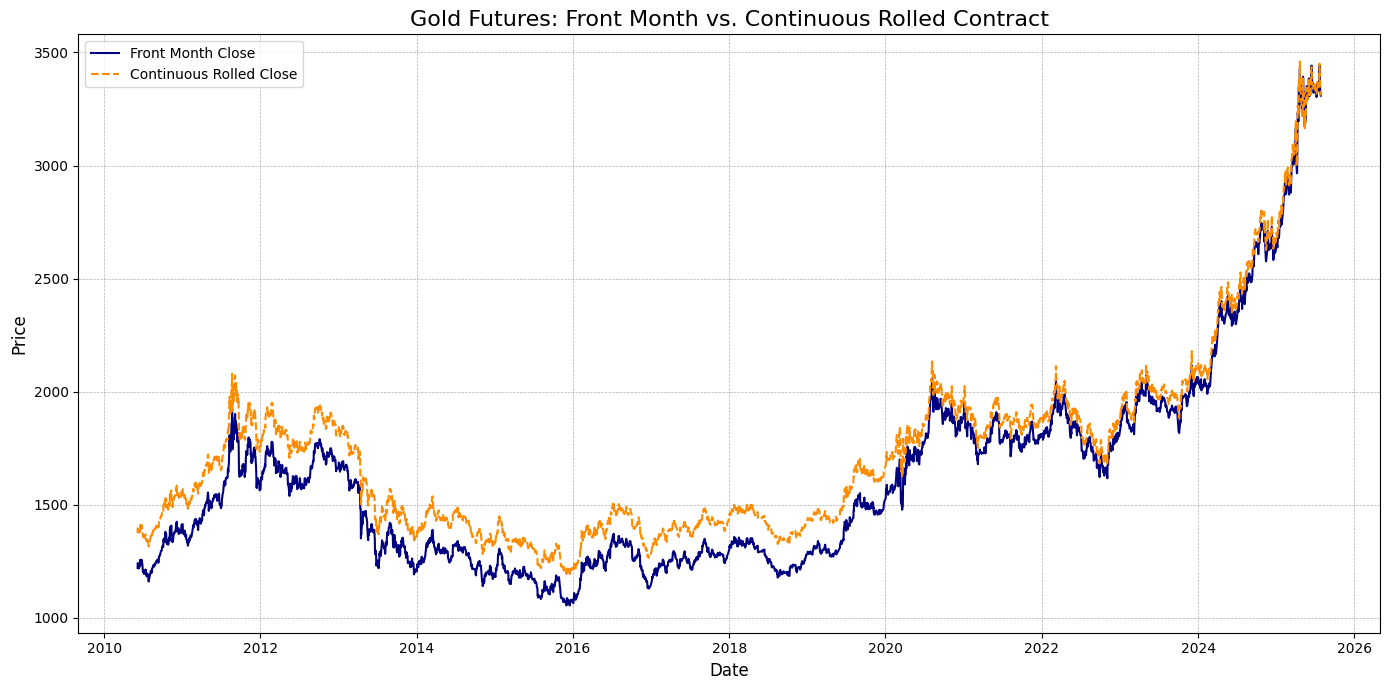

In [24]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Load the dataset and ensure 'ts_event' is a timezone-aware datetime object
df = pd.read_csv('Data/gold_futures_ohlcv.csv', parse_dates=['ts_event'])
df["ts_event"] = pd.to_datetime(df["ts_event"]).dt.tz_convert('UTC') # Ensure it's UTC

# Filter for vanilla futures contracts
single_contract_filter = (df["symbol"].str.len() == 4)
fdf = df[single_contract_filter].copy()

# Define future month codes
future_month_map = {
    'F': 1, 'G': 2, 'H': 3, 'J': 4, 'K': 5, 'M': 6,
    'N': 7, 'Q': 8, 'U': 9, 'V': 10, 'X': 11, 'Z': 12
}

# Function to determine contract year
def get_contract_year(row):
    contract_year_first_digit = int(row["symbol"][3])
    curr_year = row['ts_event'].year
    if contract_year_first_digit < curr_year % 10:
        contract_year = math.ceil(curr_year / 10) * 10 + contract_year_first_digit
    else:
        contract_year = math.floor(curr_year / 10) * 10 + contract_year_first_digit
    return contract_year

fdf["contract_year"] = fdf.apply(get_contract_year, axis=1)
fdf["contract_month"] = fdf.apply(lambda row: future_month_map[row['symbol'][2]], axis=1)

# Function to calculate months to expiry
def get_expiry_length(row):
    month = future_month_map[row['symbol'][2]]
    year = row["contract_year"]
    # Calculate the difference in months
    return (year - row['ts_event'].year) * 12 + month - row['ts_event'].month

fdf["expiry_length"] = fdf.apply(get_expiry_length, axis=1)

# Create DataFrame for front month contracts
fm_df = fdf[fdf["expiry_length"] <= 1].copy()

# Define days before expiry for the roll
DAYS_BEFORE_EXPIRY = 3

# Function to calculate the roll date
def get_roll_date(row):
    year = row["contract_year"]
    month = row["contract_month"]
    # Get all business days in the contract month
    # Using a fixed day like 28 to be safe for all months
    end_of_month = pd.to_datetime(f"{year}-{month:02d}-01") + pd.offsets.MonthEnd(0)
    bdays = pd.bdate_range(start=f"{year}-{month:02d}-01", end=end_of_month)
    # The roll date is 3 days before the 3rd to last business day
    roll_date = bdays[-3] - pd.Timedelta(days=DAYS_BEFORE_EXPIRY)
    if roll_date.weekday() == 5: # If it's a Saturday
        roll_date = roll_date - pd.Timedelta(days=1)
    return roll_date

# 1. Calculate the naive roll date
fm_df['contract_roll_date'] = fm_df.apply(get_roll_date, axis=1)
# 2. Localize the roll date to UTC to match 'ts_event'
fm_df['contract_roll_date'] = pd.to_datetime(fm_df['contract_roll_date']).dt.tz_localize('UTC')


# Identify rows where the event date is past the contract's roll date
past_roll_date_mask = (fm_df['ts_event'] > fm_df['contract_roll_date']) & (fm_df['expiry_length'] == 0)
post_roll_df = fm_df[past_roll_date_mask]

back_past_roll_date_mask = (fm_df['ts_event'] > fm_df['contract_roll_date']) & (fm_df['expiry_length'] == 0)

print("Rows in the same month but past the roll date:")
print(post_roll_df[['ts_event', 'symbol', 'contract_roll_date']].head())


# --- Create the continuous rolled contract ---
fm_df['roll_date_marker'] = fm_df.apply(lambda row: row['ts_event'].date() == row['contract_roll_date'].date(), axis=1)
fm_df['roll_date_marker'] = fm_df['roll_date_marker'] & (fm_df['expiry_length'] == 0)

# Isolate front and second month contracts
frdf = fm_df.loc[fm_df["expiry_length"] == 0].copy().set_index('ts_event')
sdf = fm_df.loc[fm_df["expiry_length"] == 1].copy().set_index('ts_event')

# Align the series and get the next month's close
frdf['next_close'] = sdf['close']
frdf = frdf.dropna()

# Calculate the spread on the roll dates
frdf['spread'] = np.nan
roll_dates = frdf[frdf['roll_date_marker']].index
frdf.loc[roll_dates, 'spread'] = frdf.loc[roll_dates, 'next_close'] - frdf.loc[roll_dates, 'close']
frdf['spread'] = frdf['spread'].fillna(0)

# Calculate cumulative adjustment for the continuous contract
frdf['cumulative_adjustment'] = frdf['spread'][::-1].cumsum()[::-1]

# Create the continuous close price
frdf['continuous_close'] = frdf['close'] + frdf['cumulative_adjustment']

print("\nContinuous Rolled Contract Data:")
print(frdf[['close', 'next_close', 'spread', 'cumulative_adjustment', 'continuous_close']].head(10))

# Plot the results for visualization
plt.figure(figsize=(14, 7))
plt.plot(frdf.index, frdf['close'], label='Front Month Close', color='navy')
plt.plot(frdf.index, frdf['continuous_close'], label='Continuous Rolled Close', linestyle='--', color='darkorange')
plt.title('Gold Futures: Front Month vs. Continuous Rolled Contract', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('continuous_futures_plot.png')